In [1]:
%pylab inline
import ML

Populating the interactive namespace from numpy and matplotlib


# COMP 598 - Lecture 3: Linear regression (Cont.)

This lecture is a continuation of the last, it also includes playing with some code that is now in ML.py

To have a unique solution, $X^TX$ needs to be non-singular/invertible (i.e full column rank or no correlation between features). It can be difficult dealing with $(X^TX)^{-1}$ in the following two cases: 

1. The weights are not uniquely defined. This means that we would need to recode or drop some of the redundant columns of $X$.
2. The number of features/weights (m) exceeds the number of training examples (n). To solve this we need to reduce the number of features.

## More features
If we have the original set of features as $X_1, \ldots, X_m$ we can increase the number of features using the following methods:

1. Numeric coding / binary coding

2. Interaction terms between two or more features $X_{m+1} = X_iX_j

3. Basis expansions, power expansions, $X_{m+1} = x_i^2$

4. Non-linear transformations of variables. $X_{m+1} = \log(X_i)$

## Linear Regression with polynomial terms

How can we investigate a hypothesis such as $f_w(x) = w_0 + w_1 x + w_2 x^2$?

Consider our previous data set

In [13]:
x = [ 0.86, 0.09, -0.85 , 0.87, -0.44, -0.43, -1.10 , 0.40, -0.96 , 0.17 ]
y =  [ 2.49 , 0.83, -0.25 , 3.10 , 0.87 , 0.02, -0.12 , 1.81, -0.83,  0.43 ]

What if this data can be better fit with a second order polynomial versus a first order polynomial? 

Let us now add a new feature which is just the square of the first feature making our hypothesis: $f_w(x) = w_0 + w_1 x + w_2x^2$.

In [3]:
x2 = np.array(x)**2
# putting it into matrix form:
data = np.matrix( [x, x2] ).T
labels = np.matrix( y ).T

In [4]:
X = ML.add_bias_term(data)
Y = labels

In [5]:
w_estimates = ML.least_squares(X,Y) #conduct least squares to obtain weight estimates

In [6]:
h = ML.Hypothesis.linear(w_estimates) #our hypothesis

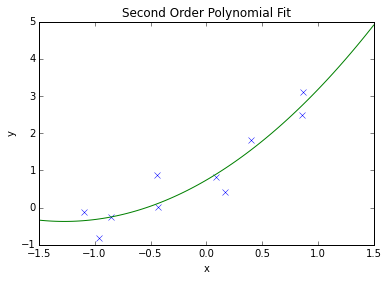

In [7]:
plt.plot(x, y, 'x')

# plotting our line of fit.
x_axis = np.linspace(-1.5, 1.5, 100)
y_estimates = h( np.matrix([ x_axis , x_axis**2] ).T ) 
plt.plot( x_axis, y_estimates)
plt.title('Second Order Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')

Can we do an even better fit? What if we try a third order polynomial? What about a fourth order? Let's try them all:

In [47]:
def multifit(x,y, max_order=11, plot=True, return_findings=False):
    """
        x,y = one-dimensional numpy arrays that are to be investigated in a
        polynomial regression.
        max_order [11] = the maximum degree polynomial you want to check
        plot [True] = plots each of the fits
        return_findings [False] = returns the results of a fit in tuples: (order, weight_estimates, MSE)
    """
    assert len(x) == len(y), 'need to have the same number of features as labels'
    Y = np.matrix(y).T
    findings = []
    for order in range(2,max_order): #order of the polynomial
        matrix_data_prep = []
    #     print 'Order '+str(order-1)+' polynomial has powers:'
        for power in range(1,order):
            # appends the powers of our x data into a matrix
    #         print str(power)
            matrix_data_prep.append(np.array(x)**power)
        X = np.matrix(matrix_data_prep).T
        X = ML.add_bias_term(X)
    #     print X

        w_estimates = ML.least_squares(X,Y)
        h = ML.Hypothesis.linear(w_estimates) #our hypothesis
        # plotting our line of fit.
        x_axis = np.linspace(min(x), max(x), 100)

        matrix_to_plot = []
        for power in range(1,order):
            # appends the powers of our x data into a matrix
            matrix_to_plot.append(np.array(x_axis)**power)

        y_estimates = h( np.matrix(matrix_to_plot ).T ) 
        
        if return_findings:
            findings.append((order, w_estimates, ML.mean_squared_error(X,Y,w_estimates)))

        if plot:
            plt.plot(x, y, 'x')
            plt.plot( x_axis, y_estimates)
            plt.title( str(order-1) + ' Order Polynomial Fit')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.ylim([min(y)-0.3, max(y)+0.3])
            plt.xlim([min(x)-0.3, max(x)+0.3])
            plt.show()
        #endif
    #endfor
    if return_findings:
        return findings
    #endif
#enddef

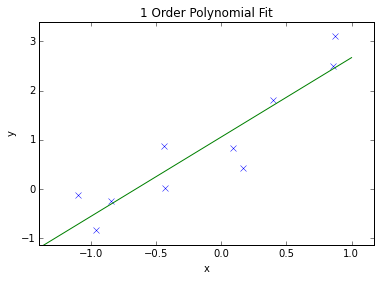

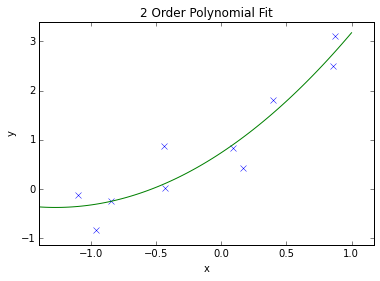

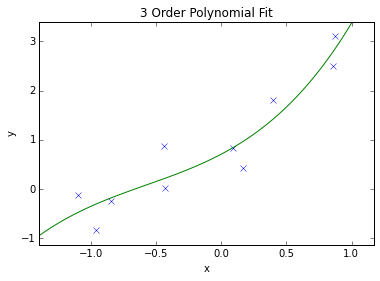

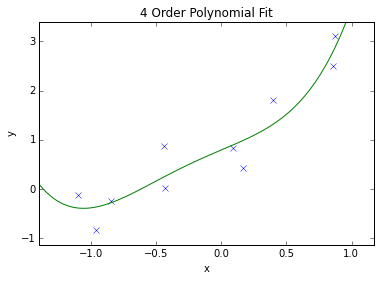

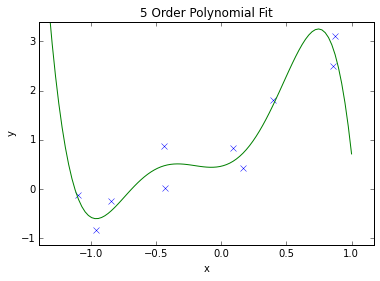

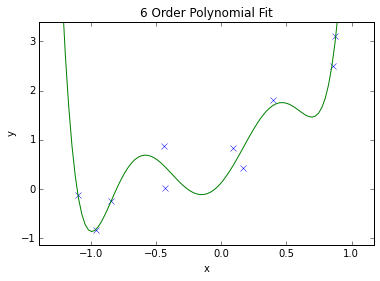

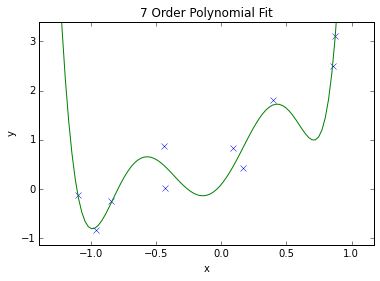

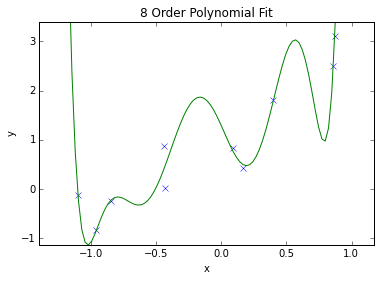

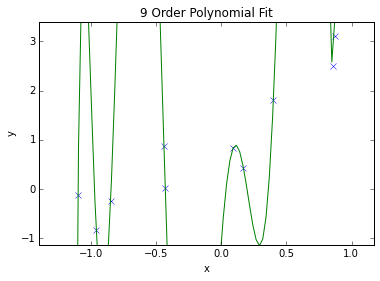

In [9]:
multifit(x,Y, plot=True, max_order=11)

The 9th order polynomial looks like a phenomenal fit. Why not check how much error it shows?

In [21]:
multifit(x,Y, return_findings=True, max_order=11, plot=False)[-1][2]

matrix([[  1.34283497e-15]])

That's a tiny error. However, just imagine if we have a new observation. Will our 9th order polynomial hypothesis $h_9$ generalize well? Probably not. The error on the *test* samples will be extremely high. Here our weights have "memorized" that data so well that they go through each of the training examples. How can we investigate this effect and make sure we pick the best order polynomial that generalizes well over a test set?

**True Error**: This is the error made by a hypothesis measured on all possible data points we can ever encounter.
However, in reality we do not have all possible observations. We woud need to do our best and measure our error over a training set.

Consider two hypothesis $h_1$ and $h_2$. Assume $h_1$ has a lower error on the training set. If $h_2$ has a lower *true* error than $h_1$, then we say that our algorithm is *overfitting*. 

**Explanation:**: We want our estimate of the true error (i.e test error) for $h_1$ to be higher than $h_1$ because know that it has the lower true error.



## Investigating the effect of overfitting on a testing set

To investigate this, the strategy we use is that we select a subset of our data to train on, and then use the other half as a testing set to estimate our error on. To do this we need more data that we generate using a sinusoidal curve with some noise.

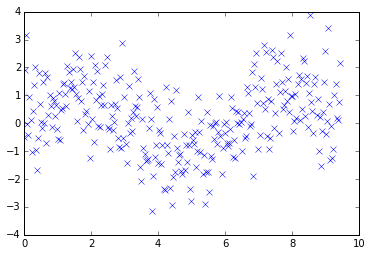

In [37]:
# creating some sinusoidal data with noise
x = np.linspace(0,3*pi, 300)
y = sin(x) + np.random.normal(loc=0, scale=1,size=len(x))
plt.plot(x,y, 'x')

In [48]:
#selecting a subset of the data by first randomizing it:
all_data = zip(x,y) # data is first zipped into tuples so we do not loose positions of each data point
np.random.shuffle(all_data)

#divide the set into two.
x_train,y_train = zip(*all_data[:len(all_data)/2])
x_test, y_test = zip(*all_data[len(all_data)/2:])

In [53]:
multifit_results = multifit(x_train,y_train,plot=False, return_findings=True) # run a polyfit on our training set

## Cross Validation
How can we compare our space hypothesis to prevent overfitting? 

We partition the training set $X,Y$ into $k$ equal subsets. For each hypothesis, we apply our algorithm $k$ times where each time we set aside one of the subsets and use the other data to find $\hat{w}$ and then measure the prediction error on the held out subset. After this we average the prediciton over the $k$ rounds for each order. We then choose the order with the lowest estimate of the true prediction error. 

**Downside:** Our compitational cost has increased $k$ times.

To experiment with this algorithm, we need a larger dataset.
